<a href="https://colab.research.google.com/github/rupeshthapa123/NotebookProject/blob/main/RupeshThapa_Lab9_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VariationalAutoEncoders



In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
latent_dim = 2

## Encoder turns images into a mean and a variance in the latent space

In [ ]:
encoder_inputs = keras.Input(shape=(28,28,1))
x=layers.Conv2D(
    32,3,activation="relu",strides=2,padding="same")(encoder_inputs)
x = layers.Conv2D(64,3,activation="relu",strides=2,padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

## Creating a Class sampler using mean and variance to sample a random point from the latent space

In [ ]:
import tensorflow as tf

class Sampler(layers.Layer):
  def call(self, z_mean, z_log_var):
    batch_size = tf.shape(z_mean)[0]
    z_size = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch_size, z_size))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Decoder network that turns points from the latent space back into images

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

## Building the model using subclass method

In [ ]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super().__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.sampler = Sampler()
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(
        name="reconstruction_loss"
    )
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  def call(self, inputs, training=None, mask=None):
    z_mean, z_log_var, z = self.encoder(inputs)
    z = self.sampler(z_mean, z_log_var)
    reconstructed = self.decoder(z)
    return reconstructed

  @property
  def metrics(self):
    return [
      self.total_loss_tracker,
      self.reconstruction_loss_tracker,
      self.kl_loss_tracker]

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var = self.encoder(data)
      z = self.sampler(z_mean, z_log_var)
      reconstruction = decoder(z)
      reconstruction_loss = tf.reduce_mean(
          tf.reduce_sum(
              keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
          )
      )
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)
      return {
          "total_loss": self.total_loss_tracker.result(),
          "reconstruction_loss": self.reconstruction_loss_tracker.result(),
          "kl_loss": self.kl_loss_tracker.result()
      }

## Training the model using compile and fit

In [ ]:
import numpy as np

(x_train, _),(x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 200s 365ms/step - total_loss: 212.2045 - reconstruction_loss: 209.9837 - kl_loss: 2.2205
Epoch 2/30
547/547 [==============================] - 184s 337ms/step - total_loss: 187.8951 - reconstruction_loss: 185.4206 - kl_loss: 2.4746
Epoch 3/30
547/547 [==============================] - 181s 330ms/step - total_loss: 178.5211 - reconstruction_loss: 175.5980 - kl_loss: 2.9230
Epoch 4/30
547/547 [==============================] - 184s 337ms/step - total_loss: 163.8358 - reconstruction_loss: 160.0626 - kl_loss: 3.7733
Epoch 5/30
547/547 [==============================] - 185s 338ms/step - total_loss: 159.1953 - reconstruction_loss: 155.3998 - kl_loss: 3.7955
Epoch 6/30
547/547 [==============================] - 190s 347ms/step - total_loss: 156.6742 - reconstruction_loss: 152.8453 - kl_loss: 3.8289
Epoch 7/30
547/547 [==============================] - 184s 337ms/step - total_loss: 155.0060 - reconstruction_loss: 151.1517 - kl_loss: 3.8543

## Decode samples from latent space and create a grid of digits

1/1 [==============================] - 0s 29ms/step


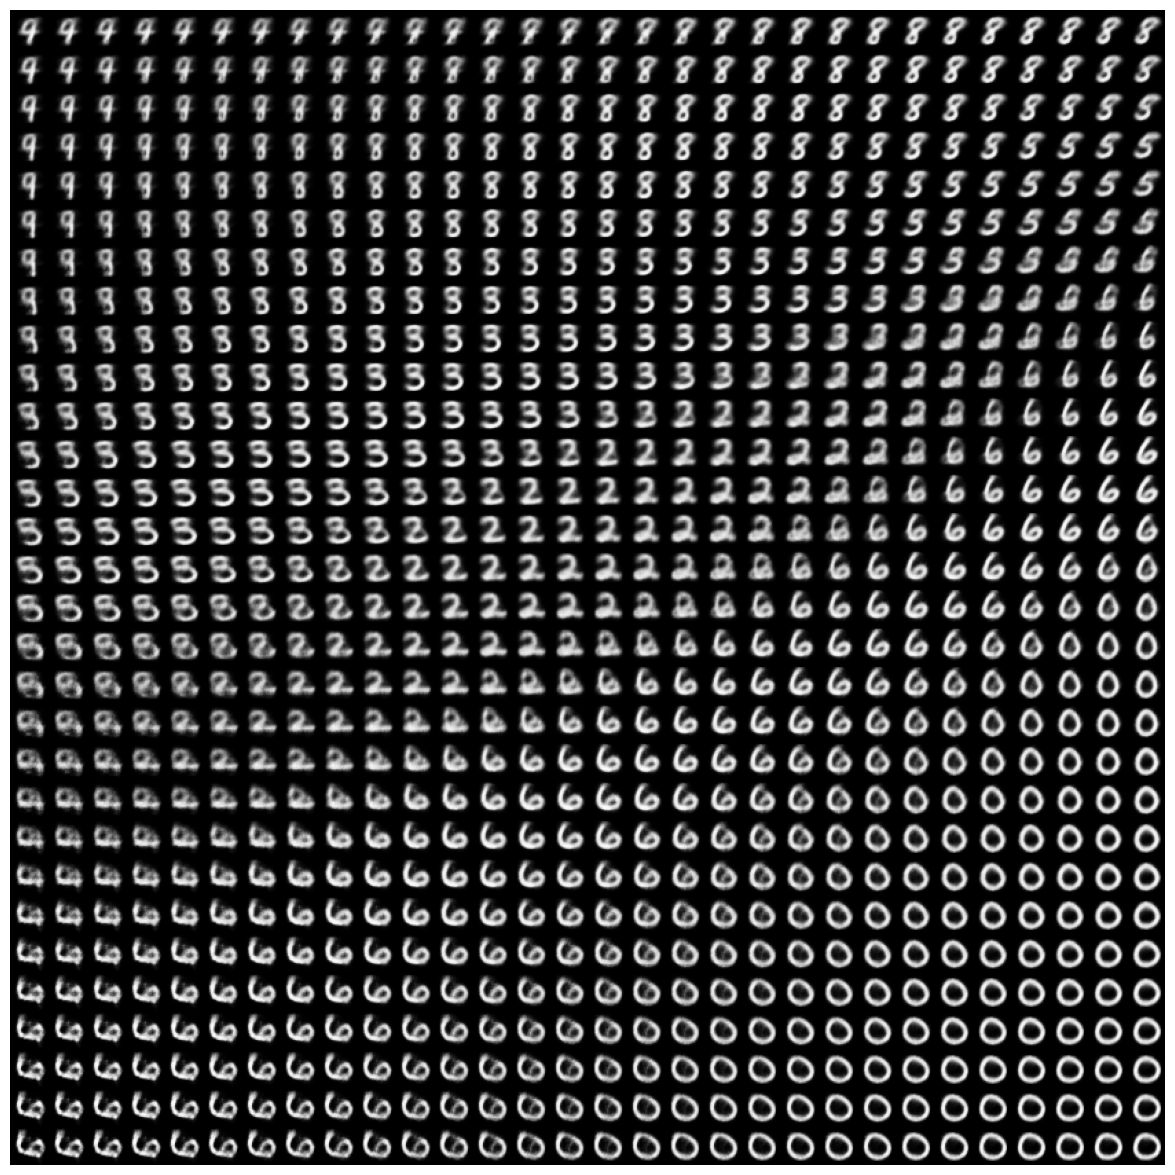

In [ ]:
import matplotlib.pyplot as plt

n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")